# Intro

This notebook implements a Jupyter widget to compare Hive-partitioned Parquet tree metadata.  The widget is based on [ipyaggrid](https://widgetti.github.io/ipyaggrid/).  The purpose of this widget is to compare output result sets from things like various Dask graph runs.  <br>
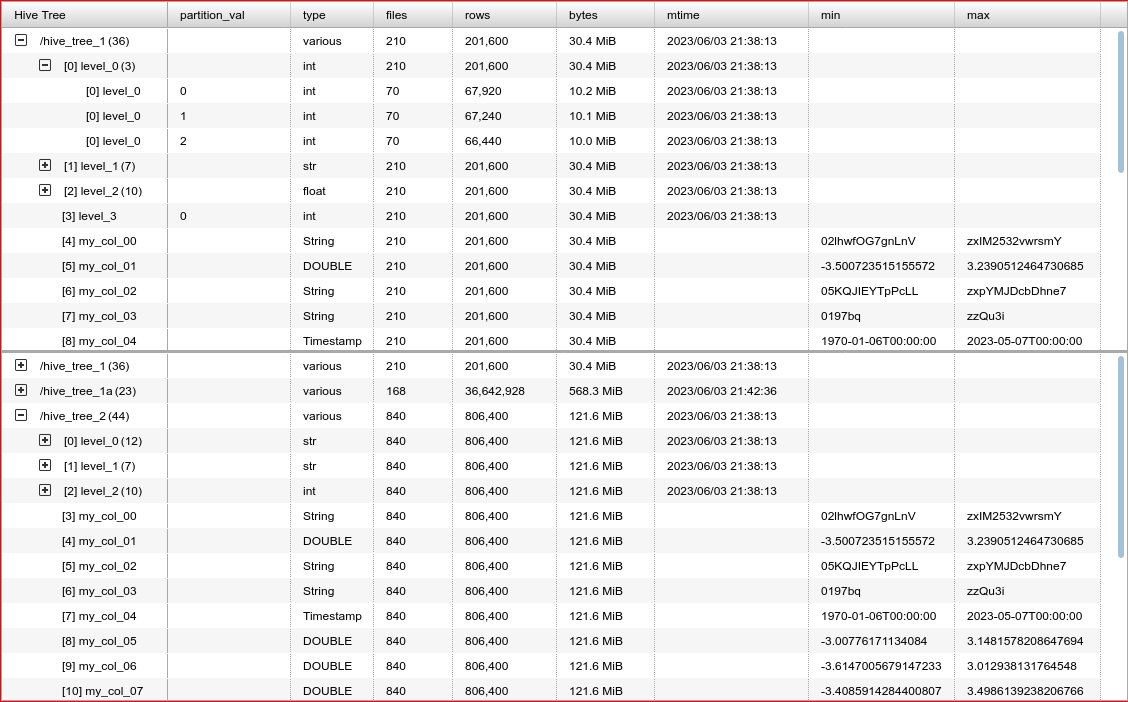

## Overview

The directory browser is implemented in a class named **twin_grid_widget** which is subclassed from **ipywidgets.VBox** so you can use it anywhere that you would use an IPython VBox widget.


A list of paths is provided to the widget, and it displays two independent duplicate split views of the metadata for all paths, allowing you to easily compare one tree to another.  The metadata is obtained by walking the file tree under each path, and quickly reading the metadata from the footer of each Parquet file.

## Installation and usage
If you use the **[ipynb](https://ipynb.readthedocs.io/en/stable/)** module, you can import this whole notebook as if it were a Python module like this:

```python
import ipynb
from ipynb.fs.defs.parquet_tree_browser_using_ipyaggrid import *
```

and then you can create a directory browser widget like this:
```python
tgw = twin_grid_widget()
tgw.display_list_of_hive_partitioned_parquet_trees(demo_hive_tree_path_list)
tgw    
```

You can install this notebook as a library like this:

```pip install 'git+https://github.com/mister-average/directory_browser_using_ipydatagrid.git'```

## Enhanced usage
If you also install the module [directory_browser_using_ipydatagrid](https://github.com/mister-average/directory_browser_using_ipydatagrid), there is an enhanced class you can use like this:

```python
cgw = combined_grid_widget()
cgw
```

This widget has a built-in directory browser that lets you interactively select the list of hive partitioned parquet directory trees that you wish to display in the twin grid widget.  This is implemented in a class named **combined_grid_widget** which is subclassed from **ipywidgets.Tab** so you can use it anywhere that you would use an IPython Tab widget.

### Warning!
If you use the **combined_grid_widget()**, you will need to click on "Autosize All Columns" after the first set of parquet trees is loaded:
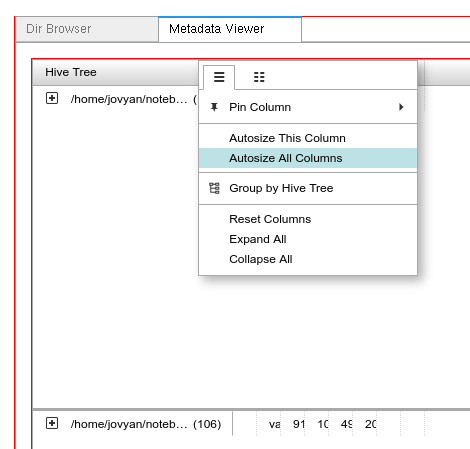

## Code organization
The organization of the code below follows this call tree:
- class **twin_grid_widget** which is subclassed from **ipywidgets.VBox** <i>- you can use it anywhere that you would use an IPython VBox widget</i><br><br>
    - class method **display_list_of_hive_partitioned_parquet_trees ()** <i>- can be called repeatedly with a new list of paths to display</i><br><br>
        - function **os_walk_list_of_hive_partitioned_parquet_trees ()**<br><br>
            - function **os_walk_hive_partitioned_parquet_tree ()** <i>- returns a Pandas Dataframe for a single hive partitioned tree</i><br><br>
                - function **guess_type_of_hive_partitions ()** <i>- given a list of hive partitions, guess a common type for all of their values</i><br><br>
                - function **get_info_about_a_parquet_file ()** <i>- uses PyArrow to read parquet file metadata</i><br><br>
        - function **generate_aggrid_rows_for_a_hive_partition_tree_df()** <i>- converts a Dataframe into summarized dicts suitable for ag-grid</i><br><br>
            - function **convert_column_to_nested ()** <i>- nests columns in a Pandas Dataframe</i><br><br>

# Imports

In [ ]:
import pandas as pd
from pandas._testing import rands_array
import numpy as np

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import datetime

In [ ]:
import pyarrow.parquet as pq 

In [ ]:
import os

In [ ]:
import ipywidgets

In [ ]:
from ipyaggrid import Grid

In [ ]:
from IPython.display import display, HTML

In [ ]:
# https://stackoverflow.com/a/23416519
from itertools import cycle

In [ ]:
import random

In [ ]:
from pprint import pprint, pformat

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Make a fake hive partitioned parquet tree
For testing, fake data can be constructed.  This function constructs several trees with multiple levels of partitioning.  For the leaf parquet files, this function makes Linux filesystem hard links from a small set of random parquet files that should be created on the same filesystem as the fake data so that hard links can work.  This keeps the test data from ballooning in size.

In [ ]:
def make_a_random_list(num_rows):
    kind = np.random.choice(['string', 'int', 'double', 'date'])
    
    if kind == 'string':
        num_chars = random.randint(5, 15)
        return rands_array(num_chars, num_rows)
    
    elif kind == 'int':
        return np.random.randint(low=0, high=1024, size=num_rows)
        
    elif kind == 'double':
        return np.random.randn(num_rows)
    
    elif kind == 'date':
        return [np.random.choice(pd.date_range(datetime.datetime(1970,1,1),datetime.datetime.now())) for i in range(num_rows)]

In [ ]:
def make_a_random_parquet_file(output_file_path, num_cols, num_rows):
    the_input = {}
    for col_num in range(num_cols):
        col_name = f'my_col_{col_num:0>2}'
        col_val = make_a_random_list(num_rows)
        the_input[col_name] = col_val
        
    the_df = pd.DataFrame(the_input)
    the_df.to_parquet(output_file_path)

In [ ]:
# This is needed so that multiple different files with the same columns but different rowcounts
# can populate a hive tree.
def copy_subset_of_a_parquet_file(source_file_path, output_file_path, new_num_rows=None):
    the_df = pd.read_parquet(source_file_path)
    
    if new_num_rows is None:
        new_num_rows = random.randint(1, len(the_df))
        
    else:
        new_num_rows = min(new_num_rows, len(the_df))
    
    new_df = the_df[:new_num_rows]
    
    new_df.to_parquet(output_file_path)

In [ ]:
def make_a_fake_hive_partitioned_parquet_tree(root_path, leaf_parquet_files, levels):
    '''
    leaf_parquet_files is a list of parquet files that will be hard linked in turn into the leaf dirs
    levels is a list of 2-tuples: (num_partitions, lambda to create partition value)
    '''
    
    list_of_dir_paths = [root_path]
    os.makedirs(root_path)
    
    # https://stackoverflow.com/a/23416519
    pool = cycle(leaf_parquet_files)

    level_num = -1
    max_level = len(levels) - 1
    for level in levels:
        level_num += 1
        
        partition_column_name='level_' + str(level_num)
        
        num_partitions, partition_value_func = level
        
        new_list_of_dir_paths = []
        for dir_path in list_of_dir_paths:
            for n in range(num_partitions):
                partition_value = partition_value_func(n)
                dir_name = partition_column_name + "=" + str(partition_value)
                
                new_dir_path = dir_path + "/" + dir_name
                os.mkdir(new_dir_path)
                
                new_list_of_dir_paths.append(new_dir_path)
                
        list_of_dir_paths = new_list_of_dir_paths
        
        if level_num == max_level:
            for leaf_dir in list_of_dir_paths:
                os.link(src=next(pool), dst=leaf_dir + "/datafile.parquet")
                
if __name__ == '__main__':
    demo_hive_tree_path_list = []
    
    # This is where the fake data will be generated
    fake_data_dir = "/var/tmp/fake_hive_trees"
    if not os.path.isdir(fake_data_dir):
        os.makedirs(fake_data_dir)
    
    
    
    # These are three parquet test files with identical columns of random data that will be hardlinked into the fake trees
    parquet_file_1_path = os.path.join(fake_data_dir, '15_columns_1680_rows.parquet')
    if not os.path.exists(parquet_file_1_path):
        print("Making fake parquet file", parquet_file_1_path)
        make_a_random_parquet_file(parquet_file_1_path, num_cols=15, num_rows=1680)
    
    parquet_file_1_path_b = os.path.join(fake_data_dir, '15_columns_1000_rows.parquet')
    if not os.path.exists(parquet_file_1_path_b):
        print("Making fake parquet file", parquet_file_1_path_b)
        copy_subset_of_a_parquet_file(parquet_file_1_path, parquet_file_1_path_b, new_num_rows=1000)
    
    parquet_file_1_path_c = os.path.join(fake_data_dir, '15_columns_200_rows.parquet')
    if not os.path.exists(parquet_file_1_path_c):
        print("Making fake parquet file", parquet_file_1_path_c)
        copy_subset_of_a_parquet_file(parquet_file_1_path, parquet_file_1_path_c, new_num_rows=200)
    
    
    
    
    
    # These are three more parquet test files with identical columns of random data that will be hardlinked into the fake trees
    parquet_file_2_path = os.path.join(fake_data_dir, '5_columns_646338_rows.parquet')
    if not os.path.exists(parquet_file_2_path):
        make_a_random_parquet_file(parquet_file_2_path, num_cols=5, num_rows=646338)
    
    parquet_file_2_path_b = os.path.join(fake_data_dir, '5_columns_6000_rows.parquet')
    if not os.path.exists(parquet_file_2_path_b):
        copy_subset_of_a_parquet_file(parquet_file_2_path, parquet_file_2_path_b, new_num_rows=6000)
    
    parquet_file_2_path_c = os.path.join(fake_data_dir, '5_columns_2000_rows.parquet')
    if not os.path.exists(parquet_file_2_path_c):
        copy_subset_of_a_parquet_file(parquet_file_2_path, parquet_file_2_path_c, new_num_rows=2000)
    
    
    
    
    # Here is the first fake test tree
    fake_data_root = "hive_tree_1"
    root_path = os.path.join(fake_data_dir, fake_data_root)
    
    if not os.path.isdir(root_path):
        print("Making fake hive partitioned tree", root_path)
        make_a_fake_hive_partitioned_parquet_tree(
            root_path,
            leaf_parquet_files = [parquet_file_1_path, 
                                  parquet_file_1_path_b,
                                  parquet_file_1_path_c
                                 ],
            levels = [ 
                (3, lambda n: n), 
                (7, lambda n: ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'][n]), 
                (10, lambda n: 100.0 + n*0.1),
                (1, lambda n: n)
            ]
        )
        
    demo_hive_tree_path_list.append(root_path)
    
    # Here is the second fake test tree
    fake_data_root = "hive_tree_1a"
    root_path = os.path.join(fake_data_dir, fake_data_root)
    
    if not os.path.isdir(root_path):
        print("Making fake hive partitioned tree", root_path)
        make_a_fake_hive_partitioned_parquet_tree(
            root_path,
            leaf_parquet_files = [parquet_file_2_path, 
                                  parquet_file_2_path_b,
                                  parquet_file_2_path_c
                                 ],
            levels = [ 
                (8, lambda n: n), 
                (3, lambda n: ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'][n+2]), 
                (7, lambda n: 100.0 + n*0.1)
            ]
        )
        
    demo_hive_tree_path_list.append(root_path)

    import calendar
    # Here is the third fake test tree
    fake_data_root = "hive_tree_2"
    root_path = os.path.join(fake_data_dir, fake_data_root)
    
    if not os.path.isdir(root_path):
        print("Making fake hive partitioned tree", root_path)
        make_a_fake_hive_partitioned_parquet_tree(
            root_path,
            leaf_parquet_files = [parquet_file_1_path, 
                                  parquet_file_1_path_b,
                                  parquet_file_1_path_c],
            levels = [ 
                (12, lambda n: calendar.month_name[n+1]), 
                (7, lambda n: ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'][n]), 
                (10, lambda x: x)
            ]
        )
        
    demo_hive_tree_path_list.append(root_path)

    # Here is the last fake test tree
    fake_data_root = "hive_tree_2a"
    root_path = os.path.join(fake_data_dir, fake_data_root)
    
    if not os.path.isdir(root_path):
        print("Making fake hive partitioned tree", root_path)
        make_a_fake_hive_partitioned_parquet_tree(
            root_path,
            leaf_parquet_files = [parquet_file_2_path, 
                                  parquet_file_2_path_b,
                                  parquet_file_2_path_c],
            levels = [ 
                (5, lambda x: calendar.month_name[x+1]), 
                (3, lambda n: ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'][n]), 
                (7, lambda x: x)
            ]
        )
        
    demo_hive_tree_path_list.append(root_path)
    pprint(demo_hive_tree_path_list)

# **def** get_info_about_a_parquet_file <b>(</b>file_path, <br>     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;hive_partition_columns_from_parent_dirs = {}, <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;hive_partition_column_ranges_from_parent_dirs = {}<b>)</b>
This function uses PyArrow to quickly read the metadata from the footer of a Parquet file.

In [ ]:
def get_info_about_a_parquet_file(file_path, hive_partition_columns_from_parent_dirs = {}, hive_partition_column_ranges_from_parent_dirs = {}, debug=False):
    
    num_parent_columns = len(hive_partition_columns_from_parent_dirs)
    num_parent_column_ranges = len(hive_partition_column_ranges_from_parent_dirs)
    if num_parent_columns != num_parent_column_ranges:
        raise RuntimeError('num_parent_columns != num_parent_column_ranges for ' + str(hive_partition_columns_from_parent_dirs) + ' ' + 
                                                                                    str(hive_partition_column_ranges_from_parent_dirs))
    
    real_path = os.path.realpath(file_path)
    ret_val = dict(path = real_path)
    
    try:
        parquet_file_metadata = pq.read_metadata(file_path)
        
    except:
        return ret_val
    
    ret_val['num_rows'] = parquet_file_metadata.num_rows
    
    # Every Parquet file will have at least one row group.
    # All row groups will have data for all columns.
    # So to get the column names and datatypes, we can
    columns = {}
    
    column_ranges = {}
    
    try:
        row_group_0 = parquet_file_metadata.row_group(0)
    except:
        return ret_val
    
    # Parquet and PyArrow have a cascade of defaults and fallbacks for column datatypes
    # that are decribed either in the column.physical_type or column.statistics.logical_type
    
    # Here are some PyArrow and Parquet docs:
    # https://arrow.apache.org/docs/python/generated/pyarrow.parquet.ColumnChunkMetaData.html
    # https://github.com/apache/parquet-format/blob/master/LogicalTypes.md
    
    # ...but the best docs that I found are here.
    # https://www.mathworks.com/help/matlab/import_export/datatype-mappings-matlab-parquet.html
    
    # So FIRST try to grab the logical type.
    
    # IF the logical_type is 'None' OR if column.statistics is not available, grab the physical type.
    
    # Finally, IF the type STARTS WITH 'Timestamp', then just set the type to 'Timestamp', otherwise
    # you will have your type list polluted with a bunch of different variants like:
    # Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false)....
    # ...which is not needed for this tool's quick comparison of column types.
    
    for column_number in range(row_group_0.num_columns):
        column = row_group_0.column(column_number)
        
        column_name = column.path_in_schema
        
        if column.statistics is None:
            column_type = column.physical_type
        else:
            column_type = str(column.statistics.logical_type)
        
        if column_type == 'None':
            column_type = column.physical_type
            
        if column_type.startswith('Timestamp'):
            column_type = 'Timestamp'
            
        columns.update({column_name:column_type})
    
    for row_group_num in range(parquet_file_metadata.num_row_groups):
        row_group = parquet_file_metadata.row_group(row_group_num)

        for column_number in range(row_group.num_columns):
            column = row_group.column(column_number)
            column_name = column.path_in_schema
            
            if column.statistics is not None:
                old_column_ranges_dict = column_ranges.setdefault(column_name, 
                                                                  { 'min': column.statistics.min, 'max': column.statistics.max })

                if column.statistics.min < old_column_ranges_dict['min']:
                    old_column_ranges_dict['min'] = column.statistics.min

                if column.statistics.max < old_column_ranges_dict['max']:
                    old_column_ranges_dict['max'] = column.statistics.max
                
            # Handle zero row files
            else:
                column_ranges[column_name] = { 'min': np.nan, 'max': np.nan }
                
            # https://issues.apache.org/jira/browse/IMPALA-5062 says that pyarrow does NOT
            # populate distinct_count and nobody who uses parquet files cares about that value.


    
    ret_val['partition_columns'] = hive_partition_columns_from_parent_dirs
    ret_val['partition_ranges'] = hive_partition_column_ranges_from_parent_dirs
    ret_val['columns'] = columns
    ret_val['ranges'] = column_ranges
    ret_val['size'] = os.path.getsize(file_path)
    ret_val['mtime'] = pd.to_datetime(os.path.getmtime(file_path), unit='s').ceil(freq='s')
    
    return ret_val
    
if __name__ == '__main__':
    demo_file = '/var/tmp/fake_hive_trees/hive_tree_1/level_0=2/level_1=tue/level_2=100.2/level_3=0/datafile.parquet'
    pprint(get_info_about_a_parquet_file(demo_file),
          width=160)
    

# <b>def</b> guess_type_of_hive_partitions <b>(</b>list_of_dir_names<b>)</b>
This function takes a list of hive partition names that would reside in the same directory, and guesses the type that could best encompass all the partition values. 

In [ ]:
# Base off https://stackoverflow.com/a/54393495
import re

def guess_types(s):
    ret_val = set()
    
    if s == "" or s is None:
        ret_val.add(None)
    
    elif re.match("\A[0-9]+\.[0-9]+\Z", s):
        ret_val.add('float')
    
    elif re.match("\A[0-9]+\.[0-9]+E[0-9]+\Z", s):
        ret_val.add('float')
    
    elif re.match("\A[0-9]+\.[0-9]+E-[0-9]+\Z", s):
        ret_val.add('float')
    
    elif re.match("\A[0-9]+\Z", s):
        ret_val.add('int')
    
    # 2019-01-01 or 01/01/2019 or 01/01/19
    elif re.match("\A[0-9]{4}-[0-9]{2}-[0-9]{2}\Z", s) or \
         re.match("\A[0-9]{2}/[0-9]{2}/([0-9]{2}|[0-9]{4})\Z", s): 
        ret_val.add('date')
    
    elif re.match("\A(true|false)\Z", s):
        ret_val.add('bool')
    
    elif re.match("\A(True|False)\Z", s):
        ret_val.add('bool')
    
    else:
        ret_val.add('str')
        
    return ret_val

def guess_type_of_hive_partitions (list_of_dir_names, parent_dir = None):
    possible_types = set()
    column_names = set()
    
    for a_dir_name in list_of_dir_names:
        format_ok = False
        
        try:
            column_name, column_value = a_dir_name.split('=', maxsplit=1)
            format_ok = True
            
        except:
            if parent_dir is None:
                print(f'Directory name {a_dir_name} is not in the format column_name=column_value')
            else:
                print(f'Directory name {a_dir_name} is not in the format column_name=column_value in', parent_dir)
            
        if format_ok:
            column_names.add(column_name)

            guessed_types = guess_types(column_value)

            if len(possible_types) == 0:
                possible_types = guessed_types

            else:
                possible_types.intersection_update(guessed_types)
        
    
    if len(column_names) > 1:
        if parent_dir is None:
            raise RuntimeError("Multiple conflicting column names are not allowed: " + str(column_names))
            
        else:
            raise RuntimeError("Multiple conflicting column names are not allowed: " + str(column_names) + ' in ' + parent_dir)
        
    if len(column_names) == 0:
        if parent_dir is None:
            print("No column names were provided! " + str(list_of_dir_names))
            
        else:
            print("No column names were provided! " + str(list_of_dir_names) + ' in ' + parent_dir)
            
        return dict()
    
    column_name = column_names.pop()
    if len(possible_types) == 0:
        return {column_name: None}
    
    column_type = possible_types.pop()
    
    return {column_name: column_type}
    
if __name__ == '__main__':
    print(guess_type_of_hive_partitions([ 'date_val=2023-02-01', 'date_val=2023-02-02', 'date_val=2023-02-03']))
    print(guess_type_of_hive_partitions([ 'sensor_val=1.1E3', 'sensor_val=2.2', 'sensor_val=3.3']))
    print(guess_type_of_hive_partitions([ 'mixed_types=2.0', 'mixed_types=0', 'mixed_types=0']))
    print(guess_type_of_hive_partitions([ 'nothing_here=0', 'nothing_here=0', 'nothing_here=0']))
    print(guess_type_of_hive_partitions([ 'pet=cat', 'pet=dog', 'pet=rock']))
    print(guess_type_of_hive_partitions([]))

# **def** os_walk_hive_partitioned_parquet_tree <b>(</b>dir_path<b>)</b>
Given a path to the root of a hive partitioned parquet tree, this function returns a Pandas Dataframe with a row for each file.  The columns that it generates are:

- **path**
- **num_rows**
- **partition_columns** <i>(based on the hive partition names encoded in the path to each file)</i>
- **partition_ranges** <i>(based on the hive partition values encoded in the path to each file)</i>
- **columns**
- **ranges** <i>(the min and max values for each column)</i>
- **size** <i>(the file size)</i>
- **mtime** <i>(the file modification time)</i>
- **root** <i>(the original dir path that was passed in as the argument to this function; meaning that each row is identical for this column)</i>

In [ ]:
def os_walk_hive_partitioned_parquet_tree (path_to_top_level_of_parquet_tree, debug=False):
    
    real_path_to_top_level_of_parquet_tree = os.path.realpath(path_to_top_level_of_parquet_tree)
    
    # This dict maps paths like this:
    #         /path/to/tree/root/column0=value0/column1=value1/column2=value2/
    # to nested dicts like this:
    #         {0: {'column0':'type0'}, 1:{'column1':'type1'}, 2:{'column2':'type2'}}
    
    dir_paths_to_dicts_of_hive_partition_column_types = {}
    
    # This dict maps paths like this:
    #         /path/to/tree/root/column0=value0/column1=value1/column2=value2/
    # to nested dicts like this:
    #         {0:{'column0':{'max': value0, 'min': value0}}, 
    #          1:{'column1':{'max': value1, 'min': value1}}, 
    #          2:{'column2':{'max': value2, 'min': value2}}}
    dir_paths_to_dicts_of_hive_partition_column_ranges = {}
    
    ret_val = []
    
    for current_root, dirs_in_current_root, files_in_current_root in os.walk(real_path_to_top_level_of_parquet_tree):
        column_types_of_current_root = dir_paths_to_dicts_of_hive_partition_column_types.get(current_root, {})
        column_ranges_of_current_root = dir_paths_to_dicts_of_hive_partition_column_ranges.get(current_root, {})
        
        # If we are not in a leaf node, there will be no files, just subdirs        
        # In a hive-partitioned tree, every directory name will have the form:
        # column_name=column_value    
        # The format of type_of_all_these_subdirs is { 'column_name':'column_type'}
        if len(dirs_in_current_root) > 0:
            if debug: print("dirs_in_current_root", dirs_in_current_root)
            col_name_to_col_type_of_any_subdir = guess_type_of_hive_partitions(dirs_in_current_root, current_root)
            if debug: print("col_name_to_col_type_of_any_subdir", col_name_to_col_type_of_any_subdir)

            column_types_for_any_subdir = {}
            column_types_for_any_subdir.update(column_types_of_current_root)
            column_types_for_any_subdir.update(col_name_to_col_type_of_any_subdir)

            for subdir_name in dirs_in_current_root:
                if '=' in subdir_name:
                    subdir_column_name, subdir_column_value = subdir_name.split('=', maxsplit=1)
                    subdir_path = os.path.join(current_root, subdir_name)

                    dir_paths_to_dicts_of_hive_partition_column_types[subdir_path] = column_types_for_any_subdir


                    column_ranges_for_this_subdir = {}
                    column_ranges_for_this_subdir.update(column_ranges_of_current_root)
                    
                    column_ranges_for_this_subdir.update({subdir_column_name:{'max': subdir_column_value, 'min': subdir_column_value}})
                    dir_paths_to_dicts_of_hive_partition_column_ranges[subdir_path] = column_ranges_for_this_subdir
                
            
        # If we are in a leaf node, there will be just files, no subdirs
        for file_name in files_in_current_root:
            if file_name != '_common_metadata' and file_name != '_metadata':
                # Have to skip those metadata parquet files that get written out into hive trees 
                file_path = os.path.join(current_root, file_name)
                file_info = get_info_about_a_parquet_file(file_path, column_types_of_current_root, column_ranges_of_current_root)

                # Handle zero row files
                if True or file_info.get('num_rows', 0) != 0:
                    file_info['root'] = real_path_to_top_level_of_parquet_tree
                    ret_val.append(file_info)
                
        
    if debug: pprint(ret_val, width=160, sort_dicts=False)
        
    ret_val_df = pd.DataFrame(ret_val)
    
    unique_column_values = pd.unique(ret_val_df['columns'].apply(str))
    
    if len(unique_column_values) != 1:
        print("    Error! Inconsistent data types for", path_to_top_level_of_parquet_tree)
        print("    ", unique_column_values)
    
    return ret_val_df

if __name__ == '__main__':
    demo_root = "/home/jovyan/notebooks/utilities/data/test/hive_tree_1"
    demo_root = demo_hive_tree_path_list[0]
    demo_df = os_walk_hive_partitioned_parquet_tree(demo_root, debug=False)
    
    demo_root2 = "/home/jovyan/notebooks/utilities/data/test/hive_tree_1a"
    demo_root2 = demo_hive_tree_path_list[1]
    demo_df2 = os_walk_hive_partitioned_parquet_tree(demo_root2, debug=False)
    display(demo_df.head(3))

# **def** os_walk_list_of_hive_partitioned_parquet_trees <br><b>(</b> hive_tree_path_list <b>)</b>
Returns a list of dataframes and the longest common prefix for the root of all the trees.

In [ ]:
def os_walk_list_of_hive_partitioned_parquet_trees ( hive_tree_path_list ):
    longest_common_root_prefix = os.path.commonpath( hive_tree_path_list )
    
    returned_list_of_dataframes = []
    
    print("\n------------------------------------------------------------------------------------")
    print('Repeatedly calling os_walk_hive_partitioned_parquet_tree()...')
    print("------------------------------------------------------------------------------------")
    
    progress_iterator = tqdm(hive_tree_path_list, leave=False)
    for hive_partitioned_tree_path in progress_iterator:
        progress_iterator.set_description(hive_partitioned_tree_path)
        returned_list_of_dataframes.append(os_walk_hive_partitioned_parquet_tree(hive_partitioned_tree_path))
        
    return returned_list_of_dataframes, longest_common_root_prefix

if __name__ == '__main__':
    demo_list_of_walked_hive_partitioned_trees, demo_longest_common_root_prefix = os_walk_list_of_hive_partitioned_parquet_trees(demo_hive_tree_path_list)
    
    for a_df in demo_list_of_walked_hive_partitioned_trees:
        display(a_df.head(1))
        
    print(demo_longest_common_root_prefix)

In [ ]:
if False:
    list_of_walked_hive_partitioned_trees = []
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/external_disks_passports.find_ls_head_200_stage_1_partitioned_parquet_output"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/external_disks_passports.find_ls_stage_1_partitioned_parquet_output"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/external_disks_passports.find_ls_stage_1_partitioned_parquet_output_blocksize_1_000_000"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/external_disks_passports.find_ls_stage_1_partitioned_parquet_output_blocksize_10_000_000"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/external_disks_passports.find_ls_stage_1_partitioned_parquet_output.test"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/external_disks_passports.find_ls_stage_2_parquet_output"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/external_disks_passports.find_ls_stage_2_parquet_output_before_removing_empty_files"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/external_disks_passports.find_ls_stage_2_parquet_output_manually_removing_empty_files"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/external_disks_passports.find_ls_stage_2_parquet_output.only_using_first_char_a"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/nbdime_tree_diff"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/sdd1_the_one_farther.find_ls_stage_1_partitioned_parquet_output"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/sdd1_the_one_farther.find_ls_stage_2_parquet_output"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/sde1_the_one_closer.find_ls_stage_1_partitioned_parquet_output"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/sde1_the_one_closer.find_ls_stage_2_parquet_output"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/sde1_the_one_closer.only"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/sde1_the_one_closer.only_full_details"))
    list_of_walked_hive_partitioned_trees.append(os_walk_hive_partitioned_parquet_tree("/home/jovyan/notebooks/data/filesystem_inventory/sde1_the_one_closer.only_merge"))
    #list_of_walked_hive_partitioned_trees

# <b>def</b> convert_column_to_nested <b>(</b>df, <br>column_label_to_expand<b>)</b>
This function does a pivot of the values in a specified column of a Pandas Dataframe into nested sub-columns of the original column.  The values in the original column must be dicts.

In [ ]:
def convert_column_to_nested(df, column_label_to_expand):
    import pandas as pd
    import numpy as np
    
    if type(df.columns) == pd.core.indexes.base.Index:
        convert_column_to_nested_in_single_column_index_dataframe(df, column_label_to_expand)
        
    elif type(df.columns) == pd.core.indexes.multi.MultiIndex:
        convert_column_to_nested_in_multi_column_index_dataframe(df, column_label_to_expand)

def convert_column_to_nested_in_single_column_index_dataframe(df, column_label_to_expand):
    old_columns = df.columns.to_list()
    new_columns = []
        
    for old_column in old_columns:
        if old_column == column_label_to_expand:
            new_columns.append((column_label_to_expand, 'dummy'))
            
        else:
            new_columns.append((old_column,))
    
    df.columns = pd.MultiIndex.from_tuples(new_columns)

    expanded_columns_df = df[column_label_to_expand, 'dummy'].apply(pd.Series)
    
    for expanded_column_label in expanded_columns_df.columns.to_list():
        df[column_label_to_expand, expanded_column_label] = expanded_columns_df[expanded_column_label]
        
    df.drop((column_label_to_expand, 'dummy'), axis=1, inplace=True)
    

def contains(sub, pri):
    '''https://stackoverflow.com/a/3847612'''
    M, N = len(pri), len(sub)
    i, LAST = 0, M-N+1
    while True:
        try:
            found = pri.index(sub[0], i, LAST) # find first elem in sub
        except ValueError:
            return [-1, -1]
        if pri[found:found+N] == sub:
            return [found, found+N-1]
        else:
            i = found+1

def get_sub_column_names(df, parent_column_name):
    ret_val = []
    
    for column_index_stack in df.columns:
        for i, column_stack_level_name in enumerate(column_index_stack):
            if column_stack_level_name == parent_column_name:
                if len(column_index_stack) > i+1:
                    ret_val.append(column_index_stack[i+1])
                    
    return ret_val

def find_matching_column_names(df, tuple_of_column_names):
    ret_val = []
    
    for column_index_stack in df.columns.tolist():
        start, end =  contains(tuple_of_column_names, column_index_stack)
        if start != -1 and end != -1:
            ret_val.append(column_index_stack)
    
    return ret_val


def convert_column_to_nested_in_multi_column_index_dataframe(df, column_label_to_expand):
    old_columns = df.columns.to_list()
    new_columns = []
    
    we_have_to_add_a_level_to_the_column_index = False
    
    saved_column_label_to_expand = column_label_to_expand
    
    if not type(column_label_to_expand) == tuple:
        column_label_to_expand = (column_label_to_expand,)
    
    found_column_label_to_expand_in_this_column = None
    for old_column in old_columns:
        start, end = contains(column_label_to_expand, old_column)
        if start != -1 and end != -1:
            found_column_label_to_expand_in_this_column = old_column
            break

    if found_column_label_to_expand_in_this_column == None:
        print("Cannot find:", column_label_to_expand, "in columns:", old_columns)
        return

    dummy_column_that_needs_to_be_dropped = None
    
    expanded_columns_df = df[found_column_label_to_expand_in_this_column].apply(pd.Series)
        
        
    for old_column in old_columns:
        new_column = list(old_column)

        if old_column == found_column_label_to_expand_in_this_column:
            
            need_to_append_dummy = True
            for i, level_label in enumerate(found_column_label_to_expand_in_this_column):
                if type(level_label) != type('string') and np.isnan(level_label):
                    new_column[i] = 'dummy'
                    need_to_append_dummy = False
                    break
                    
            if need_to_append_dummy is True:
                new_column.append('dummy')
                
            dummy_column_that_needs_to_be_dropped = tuple(new_column)
        else:
            if end == len(df.columns.levels):
                new_column.append(np.nan)

        new_column = tuple(new_column)
        new_columns.append(new_column)

    df.columns = pd.MultiIndex.from_tuples(new_columns)

        
    for expanded_column_label in expanded_columns_df.columns.to_list():
        new_column_label = list(found_column_label_to_expand_in_this_column)
        
        need_to_append_expanded_column_label = True
        for i, level_label in enumerate(found_column_label_to_expand_in_this_column):
            if type(level_label) != type('string') and np.isnan(level_label):
                new_column_label[i] = expanded_column_label
                need_to_append_expanded_column_label = False
                break
                
        if need_to_append_expanded_column_label is True:
                new_column_label.append(expanded_column_label)
                
                
        df[tuple(new_column_label)] = expanded_columns_df[expanded_column_label]
        
    if dummy_column_that_needs_to_be_dropped:
        df.drop(dummy_column_that_needs_to_be_dropped, axis=1, inplace=True)
        
if __name__ == '__main__':
    print("ORIGINAL:")
    display(demo_df.head(1))
    
    convert_column_to_nested(demo_df, 'partition_columns')
    print("After converting partition_columns to nested:")
    display(demo_df.head(1))
    
    convert_column_to_nested(demo_df, 'partition_ranges')
    print("After converting partition_ranges to nested:")
    display(demo_df.head(1))

# <b>def</b> generate_aggrid_rows_for_a_hive_partition_tree_df <b>(</b> df <b>)</b>
This function takes a Pandas Dataframe of the type returned by the function above named **os_walk_hive_partitioned_parquet_tree (dir_path)** and aggregates and summerizes it by pivoting certain columns and then grouping and aggregating by the new nested columns.  It returns the aggregated info as a list of dicts that is suitable for ipyaggrid.

In [ ]:
def generate_aggrid_rows_for_a_hive_partition_tree_df(df):
    import warnings
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
    
    import copy
    
    df = copy.deepcopy(df)
    aggrid_rows = []

    
    
#     convert_column_to_nested(df, 'partition_columns')    
#     convert_column_to_nested(df, 'columns')
#     convert_column_to_nested(df, 'partition_ranges')    
#     convert_column_to_nested(df, 'ranges')
    
    progress_iterator_0 = tqdm(['partition_columns', 'columns', 'partition_ranges', 'ranges'], leave=False)
    for nested_column_name in progress_iterator_0:
        progress_iterator_0.set_description('Initial unnesting for column ' + nested_column_name)
        convert_column_to_nested(df, nested_column_name)
    
    progress_iterator_01 = tqdm(get_sub_column_names(df, 'partition_ranges'), leave=False)
    for sub_column_name in progress_iterator_01:
        progress_iterator_01.set_description('Unnesting partition_ranges column ' + sub_column_name)
        convert_column_to_nested(df, ('partition_ranges', sub_column_name))
    
    progress_iterator_02 = tqdm(get_sub_column_names(df, 'ranges'), leave=False)
    for sub_column_name in progress_iterator_02:
        progress_iterator_02.set_description('Unnesting ranges column ' + sub_column_name)
        convert_column_to_nested(df, ('ranges', sub_column_name))

    # Validate that all rows have the same root
    try:
        root_min = df['root'].min()[0]
        
    except Exception as the_error:
        display(df)
        raise the_error
    root_max = df['root'].max()[0]
    root='MIXED'
    if root_min != root_max:
        print("Not all files have the same root!  Example:", root_min, root_max)
        return []

    else:
        root = root_min
    
    total_num_files = len(df)
    total_size = df[('size', np.nan, np.nan)].sum()
    total_num_rows = df[('num_rows', np.nan, np.nan)].sum()
    
    ##########################################################################################################################
    # PARTITION COLUMNS FIRST
    column_number_counter = 0
    progress_iterator = tqdm(get_sub_column_names(df, 'partition_columns'), desc='Unnesting partitioned columns', leave=False)
    for partition_column_name in progress_iterator:
        progress_iterator.set_description('Unnesting partitioned column ' + partition_column_name)
        
        partitioned_column_stack = find_matching_column_names(df, ('partition_columns', partition_column_name))
        assert len(partitioned_column_stack) == 1
        partitioned_column_index_val = partitioned_column_stack[0]
        
        filtered_type_rows = df[df[partitioned_column_index_val] != 'nan'].dropna()
        
        partition_column_name_type_min = filtered_type_rows[partitioned_column_index_val].min()
        partition_column_name_type_max = filtered_type_rows[partitioned_column_index_val].min()

        try:
            min_is_nan = np.isnan(partition_column_name_type_min)
        except:
            min_is_nan = False
            
        try:
            max_is_nan = np.isnan(partition_column_name_type_max)
        except:
            max_is_nan = False
            
        if not min_is_nan and not max_is_nan:
            if partition_column_name_type_min != partition_column_name_type_max:
                print(f"Not all types are identical for partition column {partition_column_name} in {root}! Example:", partition_column_name_type_min, partition_column_name_type_max)
                display(df)
                return []
            
            else:
                partition_type = partition_column_name_type_min
                
        elif min_is_nan and not max_is_nan:
            partition_type = partition_column_name_type_max
            
        elif max_is_nan and not min_is_nan:
            partition_type = partition_column_name_type_min
            
        else:
            partition_type = partition_column_name_type_min
        

        g = df.groupby(by=('partition_ranges', partition_column_name, 'min'))

        for partition_value, group in g:
            sums = group.sum(numeric_only=True)

            num_rows = sums['num_rows'][0]
            size = sums['size'][0]

            
            counts = group.count()
            count = counts[('partition_ranges', partition_column_name, 'min')]
            
            
            maxs = group.max(numeric_only=False)

            mtime = maxs[('mtime', np.nan, np.nan)]

            aggrid_dict = dict(
                root = root,
                partition_column = f'[{column_number_counter}] ' + partition_column_name,
                partition_value = partition_value,
                type = partition_type,
                num_files = count,
                num_rows = num_rows,
                byte_size = size,
                mtime = mtime.timestamp(),
                #min = partition_value,
                #max = partition_value
            )
            
            aggrid_rows.append(aggrid_dict)
            
        column_number_counter += 1
            
    ##########################################################################################################################
    # REGULAR COLUMNS SECOND
    progress_iterator2 = tqdm(get_sub_column_names(df, 'columns'), desc='Unnesting non-partitioned columns', leave=False)
    for column_name in progress_iterator2:
        progress_iterator2.set_description('Unnesting non-partitioned column ' + column_name)
        
        column_stack = find_matching_column_names(df, ('columns', column_name))
        assert len(column_stack) == 1
        column_index_val = column_stack[0]
        
        filtered_type_rows = df[df[column_index_val] != 'nan'].dropna()        

        column_name_type_min = filtered_type_rows[column_index_val].min()
        column_name_type_max = filtered_type_rows[column_index_val].max()

        try:
            min_is_nan = np.isnan(column_name_type_min)
        except:
            min_is_nan = False
            
        try:
            max_is_nan = np.isnan(column_name_type_max)
        except:
            max_is_nan = False

        if not min_is_nan and not max_is_nan:
            if column_name_type_min != column_name_type_max:
                print(f"Not all types are identical for column {column_name} in {root}! Example:", column_name_type_min, column_name_type_max)
                display(df)
                return []
            
            else:
                column_type = column_name_type_min
                
        elif min_is_nan and not max_is_nan:
            column_type = column_name_type_max
            
        elif max_is_nan and not min_is_nan:
            column_type = column_name_type_min
            
        else:
            column_type = column_name_type_min

        column_min = df[('ranges', column_name, 'min')].dropna().min()
        column_max = df[('ranges', column_name, 'max')].dropna().max()
        
        aggrid_dict = dict(
            root = root,
            column = f'[{column_number_counter}] ' + column_name,
            type = column_type,
            num_files = total_num_files,
            num_rows = total_num_rows,
            byte_size = total_size,
            min = column_min,
            max = column_max
        )

        column_number_counter += 1
        aggrid_rows.append(aggrid_dict)
        
    
            
    return aggrid_rows

if __name__ == '__main__':
#     demo_root = demo_hive_tree_path_list[0]
#     demo_df = os_walk_hive_partitioned_parquet_tree(demo_root, debug=False)
    
#     demo_aggrid_rows = generate_aggrid_rows_for_a_hive_partition_tree_df(demo_df)
#     pprint(demo_aggrid_rows)

    the_df = os_walk_hive_partitioned_parquet_tree('/home/jovyan/notebooks/data/filesystem_inventory/external_disks_passports.find_ls_stage_1_partitioned_parquet_output')
    aggrid_rows = generate_aggrid_rows_for_a_hive_partition_tree_df(the_df)

# <b>class</b> twin_grid_widget

## &#95;&#95;init&#95;&#95;()

In [ ]:
class twin_grid_widget(ipywidgets.VBox):
    def __init__(self, *args, **kwargs):
        same_or_various_aggregator = """function same_or_various_aggregator(params) {
            if (params.values.length == 0) {
                return null;
            }
            let value_so_far = params.values[0];

            for (let i = 0; i < params.values.length; i++) {
              if (params.values[i] != value_so_far) {
                  return 'various';
              }
            }
            return value_so_far;
        }"""

        # What's up with this?  The only values that should be aggregated
        # are the values in the level immediately under the partition columns.
        # This is level 1.  The other values (i.e. in the level above, for the
        # non-partitioned columns) EACH reflect the totals for the whole tree, and
        # simply need to be DUPLICATED AS IS for display in the top level tree line.
        # The max() function can perform this duplication, since all values at level 0
        # should be identical.
        SumOrMaxAggregator = """function SumOrMaxAggregator(params) {
            if (params.values.length == 0) {
                return null;
            }

            if ( params.rowNode.level == 1 ) {
                let sum_so_far = 0;
                for (let i = 0; i < params.values.length; i++) {
                  let value = params.values[i];
                  sum_so_far = sum_so_far + value;
                }
                return sum_so_far;
            }

            let max_so_far = 0;

            for (let i = 0; i < params.values.length; i++) {
              let value = params.values[i];
              if ( value > max_so_far ) {
                  max_so_far = value;
              }
            }

            return max_so_far;
        }"""


        customMinAggregator = """function customMinAggregator(params) {
            if (params.values.length == 0) {
                return null;
            }
            let min_so_far = params.values[0];

            for (let i = 0; i < params.values.length; i++) {
              if (params.values[i] < min_so_far) {
                  min_so_far = params.values[i]
              }
            }
            return min_so_far;
        }"""

        customMaxAggregator = """function customMaxAggregator(params) {
            if (params.values.length == 0) {
                return null;
            }
            let max_so_far = params.values[0];

            for (let i = 0; i < params.values.length; i++) {
              if (params.values[i] > max_so_far) {
                  max_so_far = params.values[i]
              }
            }
            return max_so_far;
        }"""

        timestampFormatter = """function timestampFormatter(params) {
            if (isNaN(params.value)) {
                return "";
            }
            var m = new Date(params.value * 1000);
            var dateString =
                m.getUTCFullYear() + "/" +
                ("0" + (m.getUTCMonth()+1)).slice(-2) + "/" +
                ("0" + m.getUTCDate()).slice(-2) + " " +
                ("0" + m.getUTCHours()).slice(-2) + ":" +
                ("0" + m.getUTCMinutes()).slice(-2) + ":" +
                ("0" + m.getUTCSeconds()).slice(-2);

            return dateString;
        }"""

        numrowsFormatter = """function numrowsFormatter(params) {
            var num = params.value;
            var commas = num.toLocaleString("en-US"); 
            return commas
        }"""

        bytesizeTooltipValueGetter = """function bytesizeTooltipValueGetter(params) {
                if (isNaN(params.value)) {
                    return "";
                }
                var bytes = params.value;
                return bytes.toFixed(0);
            }"""
        
        bytesizeFormatter = """function humanFileSize(params) {
            const si=false;
            const dp=1;
            var bytes = params.value;
            const thresh = si ? 1000 : 1024;

            if (Math.abs(bytes) < thresh) {
                return bytes + ' B';
            }

            const units = si 
                ? ['kB', 'MB', 'GB', 'TB', 'PB', 'EB', 'ZB', 'YB'] 
                : ['KiB', 'MiB', 'GiB', 'TiB', 'PiB', 'EiB', 'ZiB', 'YiB'];
            let u = -1;
            const r = 10**dp;

            do {
                bytes /= thresh;
                ++u;
            } while (Math.round(Math.abs(bytes) * r) / r >= thresh && u < units.length - 1);


            return bytes.toFixed(dp) + ' ' + units[u];
            }"""


        grid_options = {
            'suppressAggFuncInHeader' : True,
            'groupAllowUnbalanced': True,
#             'groupRemoveLowestSingleChildren': True,
            'groupRemoveSingleChildren': True,
            'showOpenedGroup' : True,
            'groupDefaultExpanded': 0,

            'autoGroupColumnDef' : {
                'headerName': 'Hive Tree',
                'pinned': 'left',
                'openByDefault': True
        #         'headerTooltip': longest_common_root_prefix
        #            'type': 'rightAligned'
        #        'minWidth': 220,
        #         cellRendererParams: {
        #             suppressCount: true,
        #             checkbox: true,
            },


            'defaultColDef' : {
                'enableRowGroup': True,
                'enablePivot': False,
                'enableValue': False,
                'sortable': False,
                'filter': True,
                'resizable': True
            },

            'groupIncludeFooter': False,
            'groupIncludeTotalFooter': False,
            
            'enableSorting': False,
            'enableFilter': True,
            'enableColResize': True,
            'enableRangeSelection': False,
            'enableBrowserTooltips' : True
        }

        columnDefs = []
        columnDefs.append({'headerName': 'root', 'field':'root', 'rowGroup':True, 'hide':True, 'type': 'rightAligned', 'tooltipField':'root'})
        columnDefs.append({'headerName': 'part_col_name', 'field':'partition_column', 'rowGroup':True, 'hide':True, 'tooltipField':'partition_column'})
        columnDefs.append({'headerName': 'col_name', 'field':'column', 'rowGroup':True, 'hide':True, 'tooltipField':'column'})
        columnDefs.append({'headerName': 'partition_val', 'field':'partition_value', 'rowGroup':False, 'hide':False, 'tooltipField':'partition_value'})
        columnDefs.append({'headerName': 'type', 'field':'type', 'rowGroup':False, 'hide':False, 'aggFunc':same_or_various_aggregator, 'tooltipField':'type'})
        columnDefs.append({'headerName': 'files', 'field':'num_files', 'rowGroup':False, 'hide':False, 'aggFunc':SumOrMaxAggregator, 'tooltipField':'num_files'})
        columnDefs.append({'headerName': 'rows', 'field':'num_rows', 'rowGroup':False, 'hide':False, 'aggFunc':SumOrMaxAggregator , 'valueFormatter':numrowsFormatter, 'tooltipValueGetter':numrowsFormatter})
        columnDefs.append({'headerName': 'bytes', 'field':'byte_size', 'rowGroup':False, 'hide':False, 'aggFunc':SumOrMaxAggregator, 'valueFormatter': bytesizeFormatter, 'tooltipValueGetter':bytesizeTooltipValueGetter})
        columnDefs.append({'headerName': 'mtime', 'field':'mtime', 'rowGroup':False, 'hide':False, 'aggFunc':'max', 'valueFormatter': timestampFormatter, 'tooltipValueGetter':timestampFormatter})
        columnDefs.append({'headerName': 'min', 'field':'min', 'rowGroup':False, 'hide':False, 'aggFunc':customMinAggregator, 'tooltipField':'min'})
        columnDefs.append({'headerName': 'max', 'field':'max', 'rowGroup':False, 'hide':False, 'aggFunc':customMaxAggregator, 'tooltipField':'max'})
        grid_options['columnDefs'] = columnDefs

        grid_options_top = dict()
        grid_options_top.update(grid_options)
        
        grid_options_bottom = dict()
        grid_options_bottom.update(grid_options)
        
        grid_options_top['alignedGrids'] = [grid_options_bottom]
        #grid_options_bottom['alignedGrids'] = [grid_options_top]
        
        # ['ag-theme-balham', 'ag-theme-balham-dark', 'ag-theme-material', 'ag-theme-fresh', 'ag-theme-dark', 'ag-theme-blue', 'ag-theme-bootstrap', 
        # 'ag-theme-excel']
        display(HTML("""
<style>
.ag-theme-fresh {
    font-size: 11px !important;
}
</style>"""))
        
        display(HTML("""
<style>
.bottom_grid_class .ag-header {
    height: 0px !important;
    min-height: 0px !important;
}
</style>"""))
        
#         display(HTML("""
# <style>
# .ag-theme-fresh {
#     --ag-font-size: 11px !important;
#     --ag-font-family: monospace !important;
#     --ag-header-foreground-color: rgb(255, 0, 0);
# }
# </style>"""))
        
        self.top_grid = Grid(grid_data=[], 
                             theme='ag-theme-fresh',
                             grid_options = grid_options_top, 
                             js_pre_grid = ["""window.go_top = gridOptions;"""],
                             columns_fit="auto")
        
        self.bottom_grid = Grid(grid_data=[], 
                                grid_options = grid_options_bottom, 
                                js_pre_grid = ["""
                                window.go_bottom = gridOptions;
                                
                                window.go_top.alignedGrids.push(window.go_bottom);
                                window.go_bottom.alignedGrids.push(window.go_top);
                                """],
                                columns_fit="auto")
        self.bottom_grid.add_class("bottom_grid_class")
        ipywidgets.VBox.__init__(self, [self.top_grid, self.bottom_grid], layout=ipywidgets.Layout(border="1px solid red") )

## display_list_of_hive_partitioned_parquet_trees ( self, <br>     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;hive_tree_path_list, <br>     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;trim_off_common_root_prefixes = True )

In [ ]:
class twin_grid_widget(twin_grid_widget):
    def display_list_of_hive_partitioned_parquet_trees ( 
        self,
        hive_tree_path_list,
        trim_off_common_root_prefixes = True
        ):


        list_of_walked_hive_partitioned_tree_dfs, longest_common_root_prefix = os_walk_list_of_hive_partitioned_parquet_trees(hive_tree_path_list)

        aggrid_rows = []

        print("\n------------------------------------------------------------------------------------")
        print("Repeatedly calling generate_aggrid_rows_for_a_hive_partition_tree_df()...")
        print("------------------------------------------------------------------------------------")
        
        zipped_list = list(zip(hive_tree_path_list, list_of_walked_hive_partitioned_tree_dfs))
        
        progress_iterator = tqdm(zipped_list, leave=False)
        
        for hive_tree_path, walked_hive_partitioned_tree_df in progress_iterator:
            progress_iterator.set_description(hive_tree_path)
            
            if len(walked_hive_partitioned_tree_df) == 0:
                print("Found ZERO ROWS for:", hive_tree_path)
                continue
                
            if trim_off_common_root_prefixes and len(hive_tree_path_list) > 1:
                walked_hive_partitioned_tree_df['root'] = walked_hive_partitioned_tree_df['root'].str.replace(longest_common_root_prefix, '')

            aggrid_rows.extend(generate_aggrid_rows_for_a_hive_partition_tree_df(walked_hive_partitioned_tree_df))

        
        print("\n------------------------------------------------------------------------------------")
        print("Done with all loads.")
        print("------------------------------------------------------------------------------------")
        self.top_grid.update_grid_data(aggrid_rows)
        self.bottom_grid.update_grid_data(aggrid_rows)

In [ ]:
if __name__ == '__main__':
    tgw = twin_grid_widget()
    display(tgw)
    
    real_path_list = [
                       '/home/jovyan/notebooks/data/filesystem_inventory/sdd1_the_one_farther.find_ls_stage_2_parquet_output', 
                       '/home/jovyan/notebooks/data/filesystem_inventory/sde1_the_one_closer.find_ls_stage_2_parquet_output', 
                       '/home/jovyan/notebooks/data/filesystem_inventory/sde1_the_one_closer.only', 
                       '/home/jovyan/notebooks/data/filesystem_inventory/sde1_the_one_closer.only_full_details', 
                       '/home/jovyan/notebooks/data/filesystem_inventory/sde1_the_one_closer.only_merge'
    ]
    
    fake_path_list = ['/var/tmp/fake_hive_trees/hive_tree_1',
                      '/var/tmp/fake_hive_trees/hive_tree_1a',
                      '/var/tmp/fake_hive_trees/hive_tree_2',
                      '/var/tmp/fake_hive_trees/hive_tree_2a'
    ]
    tgw.display_list_of_hive_partitioned_parquet_trees(fake_path_list, trim_off_common_root_prefixes=True)

# **class** combined_grid_widget

## &#95;&#95;init&#95;&#95;()

In [ ]:
class combined_grid_widget(ipywidgets.Tab):
    def __init__(self, *args, initial_path = None, **kwargs):
        try:
            from ipynb.fs.defs.directory_browser_using_ipydatagrid import filepaths_table

        except Exception as import_exception:
            print ("Prerequisite for combined_grid_widget is missing!  Please install the prerequisite like this:")
            print ("pip install 'git+https://github.com/mister-average/directory_browser_using_ipydatagrid.git'")
            return None

        if initial_path is None:
            initial_path = os.getcwd()
        
        self.fpt = filepaths_table(initial_path=initial_path)
        self.tgw = twin_grid_widget()
        
        ipywidgets.Tab.__init__(self, layout=ipywidgets.Layout(border="1px solid red") )
        
        self.children = [self.fpt, self.tgw]
        self.titles = ['Dir Browser', 'Metadata Viewer']
        
        self.fpt.set_selection_callback(self.display_dirpath_list)

In [ ]:
class combined_grid_widget(combined_grid_widget):
    def display_dirpath_list ( self, path_list ):
        self.selected_index = 1
        pprint(path_list)
        print("")
        self.tgw.display_list_of_hive_partitioned_parquet_trees(path_list)

In [ ]:
if __name__ == '__main__':
    cwg = combined_grid_widget()
    cwg

In [ ]:
import IPython
IPython.display.Javascript("IPython.OutputArea.auto_scroll_threshold = 9999;")